In [1]:
# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast, TFAutoModel

# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
import tensorflow as tf
import re
import numpy as np
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
!unzip ../input/toxic-comm/train.csv
!unzip ../input/toxic-comm/test.csv

unzip:  cannot find or open ../input/toxic-comm/train.csv, ../input/toxic-comm/train.csv.zip or ../input/toxic-comm/train.csv.ZIP.
unzip:  cannot find or open ../input/toxic-comm/test.csv, ../input/toxic-comm/test.csv.zip or ../input/toxic-comm/test.csv.ZIP.


In [4]:
df=pd.read_csv('/kaggle/input/toxicity/train.csv')

df = df.sample(frac=1)

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
130507,ba2ee34449dbd5f1,Yes it was Dick. The consensus was overwhelmi...,0,0,0,0,0,0
33117,5821164f7c93c432,Basically I dont entirely agree that the gourm...,0,0,0,0,0,0
48014,8042fe551cb9134d,DeCausa you are such an idiot. I was talking a...,1,0,0,0,0,0
50823,87e2f197b536e986,"""::::::::: It is unprudent to claim that the f...",0,0,0,0,0,0
90428,f1f884a879a74378,I guess it's a good removal. Just so you know...,0,0,0,0,0,0


In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [7]:
df['comment_text'] = df['comment_text'].map(lambda x : clean_text(x))

In [8]:
train_sentences = df["comment_text"].fillna("CVxTz").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_y = df[list_classes].values

In [9]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
130507,ba2ee34449dbd5f1,yes it was dick the consensus was overwhelming...,0,0,0,0,0,0
33117,5821164f7c93c432,basically i dont entirely agree that the gourm...,0,0,0,0,0,0
48014,8042fe551cb9134d,decausa you are such an idiot i was talking ab...,1,0,0,0,0,0
50823,87e2f197b536e986,it is unprudent to claim that the fact who sta...,0,0,0,0,0,0
90428,f1f884a879a74378,i guess it a good removal just so you know axi...,0,0,0,0,0,0


In [10]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 128

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
#config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
bert = TFAutoModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32') 
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
x = bert.bert(inputs)

In [12]:
#x2 =Dense(512, activation='relu')(x[1])
x2 = GlobalAveragePooling1D()(x[0])
#x3 = Dropout(0.5)(x2)
y =Dense(len(list_classes), activation='sigmoid', name='outputs')(x2)

model = Model(inputs=inputs, outputs=y)
#model.layers[2].trainable = False

# Take a look at the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [13]:
#optimizer = Adam(lr=1e-5, decay=1e-6)
import tensorflow as tf


optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)

model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [ ]:
# Tokenize the input 
x = tokenizer(
    text=list(train_sentences),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


In [ ]:
history = model.fit(
    x={'input_ids': x['input_ids'], 'attention_mask': x['attention_mask']},
    #x={'input_ids': x['input_ids']},
    y={'outputs': train_y},
    validation_split=0.1,
    batch_size=32,
    epochs=1)

In [17]:
test_df=pd.read_csv("/kaggle/input/toxicity/test.csv")
test_df['comment_text']=test_df['comment_text'].map(lambda x : clean_text(x))
test_sentences = test_df["comment_text"].fillna("CVxTz").values

In [18]:
import gc
gc.collect()

27097

In [26]:
from keras.models import load_model
loaded_bert = load_model('/kaggle/input/bert-ultimate/bert_trained_final_model.h5')

In [ ]:
loaded_bert.get_config()

In [21]:
test_labels = pd.read_csv('/kaggle/input/toxicity/test_labels.csv')

In [22]:
remove_ids = test_labels[test_labels.iloc[:, 1:].eq(-1).all(axis=1)]['id']

labels = test_labels[~test_labels['id'].isin(remove_ids)]
test_df = test_df[~test_df['id'].isin(remove_ids)]

In [23]:
#test_df - id,comment_text
labels.iloc[:,1:].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [24]:
test_x = tokenizer(
    text=list(test_df['comment_text'].values),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [27]:
predictions=loaded_bert.predict(x={'input_ids': test_x['input_ids'], 'attention_mask': test_x['attention_mask']},batch_size=32)

2000/2000 [==============================] - 554s 276ms/step


In [28]:
print(len(predictions.flatten()))
print(len(labels.values.flatten()))


383868
447846


In [29]:
predictions

array([[7.0799033e-05, 1.3874775e-04, 7.8257312e-05, 1.6213236e-04,
        1.2238120e-04, 1.3761906e-04],
       [3.0812570e-01, 8.3822099e-04, 1.1380798e-02, 1.6186968e-03,
        1.5471352e-02, 3.1582098e-03],
       [2.0001946e-01, 3.0463739e-04, 1.9237638e-02, 2.0776481e-04,
        1.3193617e-02, 3.4007535e-03],
       ...,
       [9.4483662e-01, 8.7209186e-03, 4.0928349e-02, 7.5737708e-03,
        2.8143835e-01, 2.8503871e-01],
       [9.9881893e-01, 3.3961695e-01, 9.8885870e-01, 6.2145418e-03,
        9.6870226e-01, 4.3145341e-01],
       [2.3662962e-04, 7.3324307e-05, 1.6739125e-04, 9.2893839e-05,
        2.7054286e-04, 1.7119144e-04]], dtype=float32)

In [45]:
predictions = np.where(predictions <=0.05,0,1)
print(len(predictions))

63978


In [31]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
acc = accuracy_score(labels.iloc[:, 1:].values.flatten(),predictions.flatten())
print("accuracy on test_data = ",acc)

accuracy on test_data =  0.9248153010930841


In [44]:
#labels = labels.drop('id',axis = 1)
labels_array = labels.values
labels_array

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [32]:
prec =precision_score(labels.iloc[:, 1:].values.flatten(),predictions.flatten())
print("precision on test_data = ",prec)

recall =recall_score(labels.iloc[:, 1:].values.flatten(),predictions.flatten())
print("recall on test_data = ",recall)

f1 =f1_score(labels.iloc[:, 1:].values.flatten(),predictions.flatten())
print("f1 on test_data = ",f1)

precision on test_data =  0.33097182667639513
recall on test_data =  0.9699268864670989
f1 on test_data =  0.49353338597876634


false positive rate =  [0.         0.19285517 1.        ]
true positive rate =  [0.         0.98669951 1.        ]
threshold =  [2 1 0]
roc_auc =  0.8969221693938626


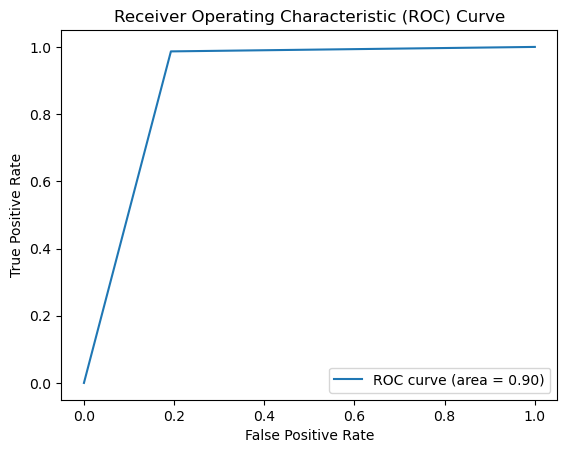

false positive rate =  [0.        0.0410778 1.       ]
true positive rate =  [0.         0.96457766 1.        ]
threshold =  [2 1 0]
roc_auc =  0.961749927833245


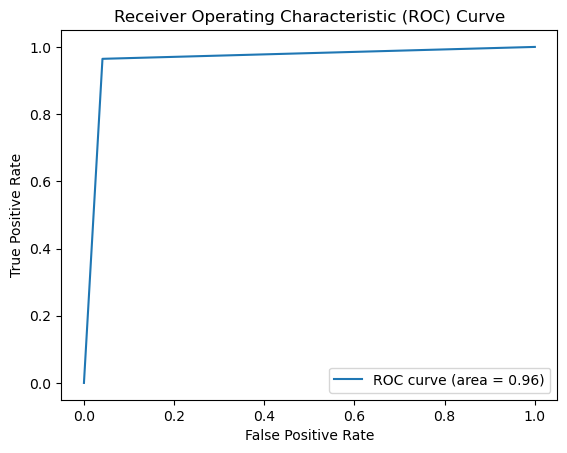

false positive rate =  [0.         0.10083434 1.        ]
true positive rate =  [0.        0.9666757 1.       ]
threshold =  [2 1 0]
roc_auc =  0.9329206776236869


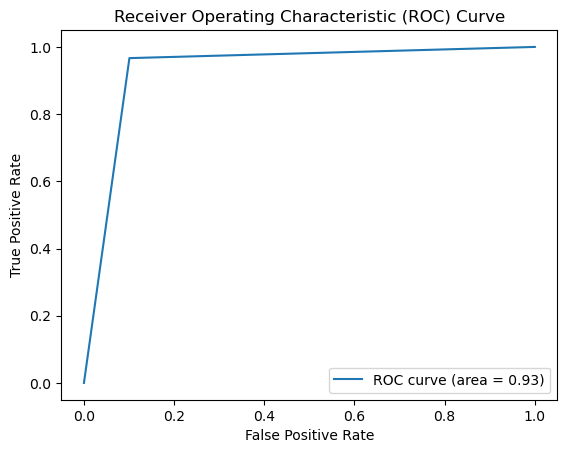

false positive rate =  [0.         0.00608465 1.        ]
true positive rate =  [0.         0.84834123 1.        ]
threshold =  [2 1 0]
roc_auc =  0.9211282901457669


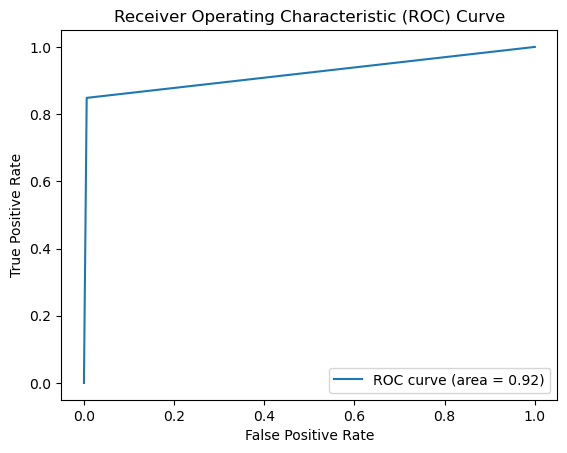

false positive rate =  [0.         0.12016317 1.        ]
true positive rate =  [0.         0.97052816 1.        ]
threshold =  [2 1 0]
roc_auc =  0.9251824952505389


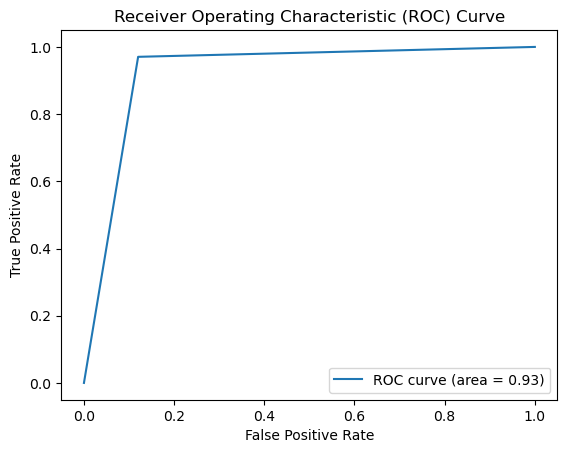

false positive rate =  [0.         0.01430468 1.        ]
true positive rate =  [0.         0.87921348 1.        ]
threshold =  [2 1 0]
roc_auc =  0.9324544006632244


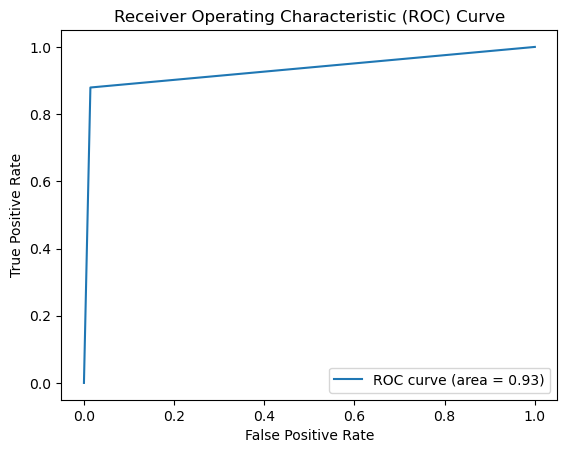

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,confusion_matrix
for i,lab in enumerate(labels.columns):
    true = labels[lab].values
    pred = predictions[:,i]
    false_pos_rate, true_pos_rate, t = roc_curve(true,pred)
    print("false positive rate = ",false_pos_rate)
    print("true positive rate = ",true_pos_rate)
    print("threshold = ",t)
    roc_auc = auc(false_pos_rate, true_pos_rate)
    print("roc_auc = ",roc_auc)
    # Plot the ROC curve
    plt.figure()
    plt.plot(false_pos_rate, true_pos_rate, label='ROC curve (area = %0.2f)' % roc_auc)
    #plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


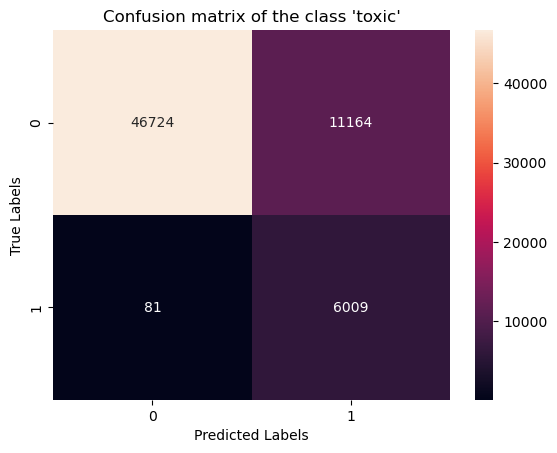

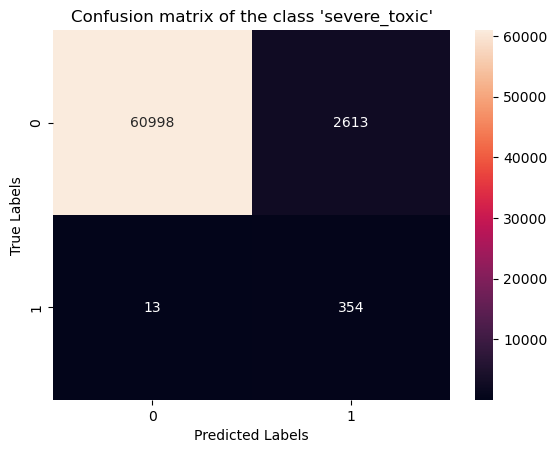

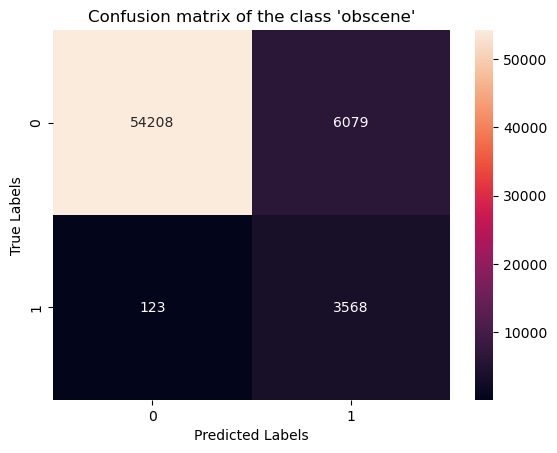

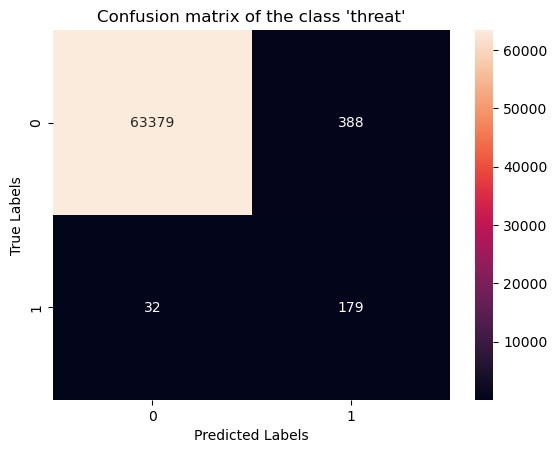

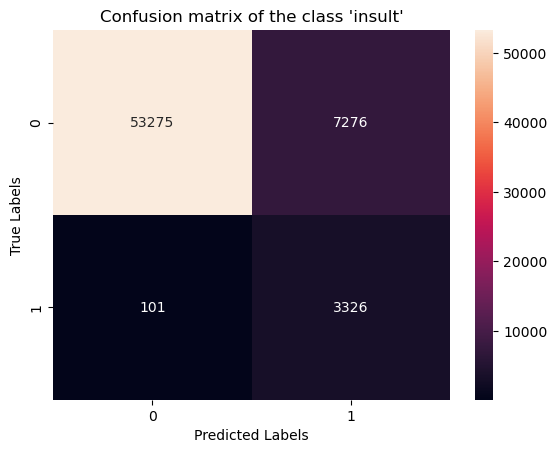

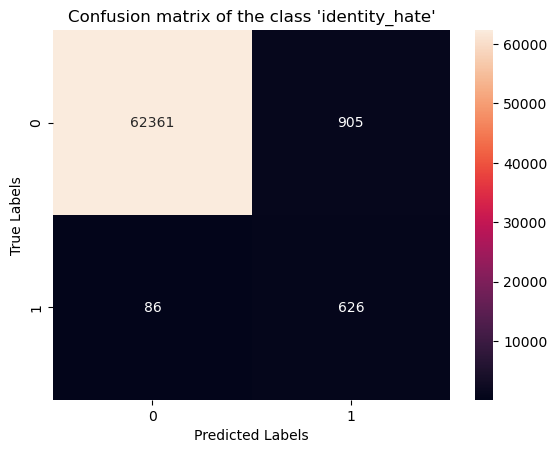

In [55]:
import seaborn as sns
for i, column in enumerate(labels.columns):
    true_labels = labels[column].values
    predicted_labels = predictions[:, i] 
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(confusion_mat, annot=True, fmt='d')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"Confusion matrix of the class '{column}'")
    plt.show()

In [34]:
submission=pd.DataFrame(predictions,columns=list_classes)
submission['id'] = test_df['id']
submission=submission[['id']+(list_classes)]
submission.to_csv("submission.csv", index=False)

In [35]:
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,NaN,0,0,0,0,0,0
1,NaN,1,0,0,0,0,0
2,NaN,1,0,0,0,0,0
3,NaN,0,0,0,0,0,0
4,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...
63973,NaN,0,0,0,0,0,0
63974,NaN,1,0,1,0,1,0
63975,NaN,1,0,0,0,1,1
63976,NaN,1,1,1,0,1,1


In [36]:
model.save('bert_trained_final_model.h5')

In [ ]:
array([[9.96451855e-01, 3.19595575e-01, 9.73300993e-01, 6.66408241e-02,
        8.55655074e-01, 4.04498100e-01],
       [3.82236525e-04, 6.90641173e-05, 9.02574902e-05, 3.87122745e-05,
        7.63346252e-05, 5.26799959e-05],
       [3.87398381e-04, 8.71204174e-05, 6.86359708e-05, 5.11232574e-05,
        5.49824690e-05, 1.14178227e-04],
       ...,
       [2.30807578e-04, 1.04336636e-04, 1.28626460e-04, 8.19144043e-05,
        5.18320667e-05, 5.61523448e-05],
       [1.04282412e-03, 1.59318806e-04, 1.92810679e-04, 1.54616311e-04,
        1.37808558e-04, 4.32897126e-04],
       [9.83495533e-01, 1.10124229e-02, 8.11580837e-01, 2.28242413e-03,
        4.43040758e-01, 5.30825322e-03]], dtype=float32)
add Codeadd Markdown